In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Final_project/kaggle.json ~/.kaggle/
!kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.67G/3.69G [00:42<00:00, 129MB/s]
100% 3.69G/3.69G [00:42<00:00, 92.4MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/respiratory-sound-database.zip','r')
zip_ref.extractall('/content/drive/MyDrive/Dataset/Audio_Files')
zip_ref.close()

In [ ]:
path="/content/drive/MyDrive/Dataset/Audio_Files/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files"

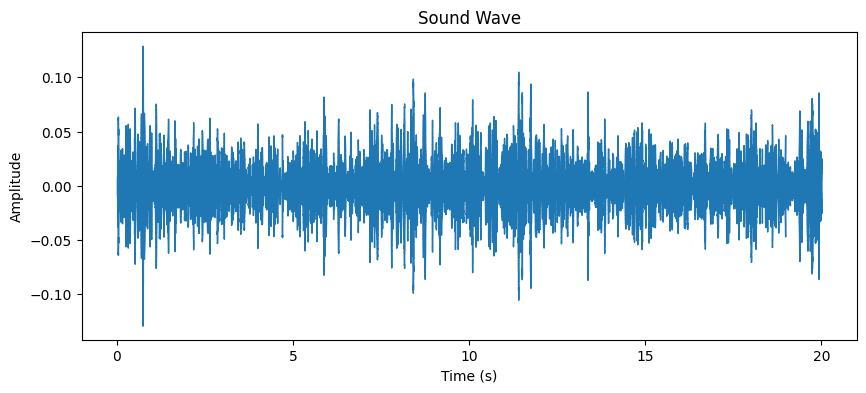

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file
file_path = '/content/drive/MyDrive/Dataset/Audio_Files/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav'
signal, sample_rate = librosa.load(file_path, sr=None)

# Display the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=sample_rate)
plt.title('Sound Wave')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


In [ ]:
import os
import shutil
import numpy as np
import scipy.signal as signal
from scipy.io.wavfile import write

In [ ]:
# denoise function
def Denoise(raw_audio, sample_rate, filter_order, filter_lowcut, filter_highcut, btype="bandpass"):
    b,a =0,0
    if btype=="bandpass":
        b,a=signal.butter(filter_order,[filter_lowcut/(sample_rate/2), filter_highcut/(sample_rate/2)], btype=btype)
    if btype=="highpass":
        b,a=signal.butter(filter_order,filter_lowcut, btype=btype, fs=sample_rate)

    audio=signal.lfilter(b, a, raw_audio)
    return audio

In [ ]:
denpath="/content/drive/MyDrive/Dataset/denoised_audio"
sample_rate = 4000
filter_lowcut = 50
filter_highcut = 1800
filter_order = 5
filter_btype = "bandpass"
for filename in os.listdir(path):
    adfile=os.path.join(path,filename)
    # load data
    raw_audio, sample_rate = librosa.load(adfile, sr=sample_rate)
    # Noise reduction method, filter
    audio_data = Denoise(raw_audio, sample_rate, filter_order,filter_lowcut,filter_highcut, btype=filter_btype)
    save_path=os.path.join(denpath,filename)
    write(save_path, sample_rate, audio_data)


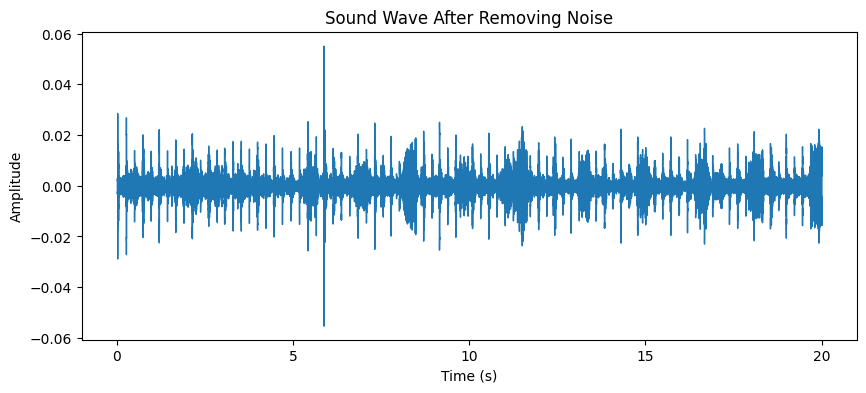

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file
file_path = '/content/drive/MyDrive/Dataset/denoised_audio/102_1b1_Ar_sc_Meditron.wav'
signal, sample_rate = librosa.load(file_path, sr=None)

# Display the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=sample_rate)
plt.title('Sound Wave After Removing Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# creating logmel spectograms from the denoised audio files
def create_spectogram(file_path,filename,save_path):
    plt.interactive(False)
    file_audio_series,sr = librosa.load(file_path,sr=None)
    spec_image = plt.figure(figsize=[1,1])
    ax = spec_image.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    spectogram = librosa.feature.melspectrogram(y=file_audio_series, sr=sr)
    librosa.display.specshow(librosa.power_to_db(spectogram, ref=np.max))

    image_name  = os.path.join(save_path,filename)
    plt.savefig(image_name, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()
    spec_image.clf()
    plt.close(spec_image)
    plt.close('all')

In [ ]:
import os
import pandas as pd

data=pd.read_csv("/content/drive/MyDrive/Dataset/Data.csv")
ids={}
cpath="/content/drive/MyDrive/Dataset/denoised_audio"
save_path="/content/drive/MyDrive/Dataset/logmel"
for i in os.listdir(cpath):
    adpath=os.path.join(cpath,i)
    if (i.split('_')[0]).isnumeric()==True:
        k=data[data['ID']=='ID'+i.split('_')[0]]["ID"].values[0]
        d=data[data['ID']=='ID'+i.split('_')[0]]["Disease"].values[0]
        if d!='LRTI':
          if k in ids:
              ids[k]+=1
          else:
              ids[k]=1
          filename=k+str(ids[k])+'_'+d
          create_spectogram(adpath,filename,save_path)
    else:
        k=data[data['ID']==i.split('_')[0]]["Disease"].values
        if len(k)!=0:
            filename=i.split('_')[0]+"_"+k[0]
            create_spectogram(adpath,filename,save_path)

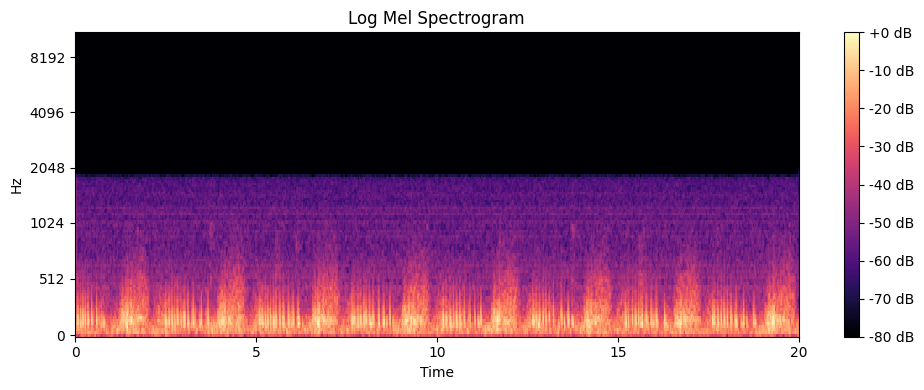

In [ ]:
# displaying Log mel spectogram
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
audio_file = "/content/drive/MyDrive/Dataset/denoised_audio/146_8p3_Pr_mc_AKGC417L.wav"
y, sr = librosa.load(audio_file)

# Compute the log mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
log_S = librosa.power_to_db(S, ref=np.max)

# Display the log mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel Spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
# creating logmel mfcc spectograms from the denoised audio files
def create_mfcc(file_path,filename,save_path):
    plt.interactive(False)
    file_audio_series,sr = librosa.load(file_path,sr=None)
    spec_image = plt.figure(figsize=[1,1])
    ax = spec_image.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    spectogram = librosa.feature.melspectrogram(y=file_audio_series, sr=sr)
    logmel=librosa.power_to_db(spectogram, ref=np.max)
    mfccs = librosa.feature.mfcc(S=logmel, n_mfcc=20)
    librosa.display.specshow(mfccs)
    image_name  = os.path.join(save_path,filename)
    plt.savefig(image_name, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()
    spec_image.clf()
    plt.close(spec_image)
    plt.close('all')

In [ ]:
import os
import pandas as pd

data=pd.read_csv("/content/drive/MyDrive/Dataset/Data.csv")
ids={}
cpath="/content/drive/MyDrive/Dataset/denoised_audio"
save_path="/content/drive/MyDrive/Dataset/mfcc20"
for i in os.listdir(cpath):
    adpath=os.path.join(cpath,i)
    if (i.split('_')[0]).isnumeric()==True:
        k=data[data['ID']=='ID'+i.split('_')[0]]["ID"].values[0]
        d=data[data['ID']=='ID'+i.split('_')[0]]["Disease"].values[0]
        if d!='LRTI':
          if k in ids:
              ids[k]+=1
          else:
              ids[k]=1
          filename=k+str(ids[k])+'_'+d
          create_mfcc(adpath,filename,save_path)
    else:
        k=data[data['ID']==i.split('_')[0]]["Disease"].values
        if len(k)!=0:
            filename=i.split('_')[0]+"_"+k[0]
            create_mfcc(adpath,filename,save_path)

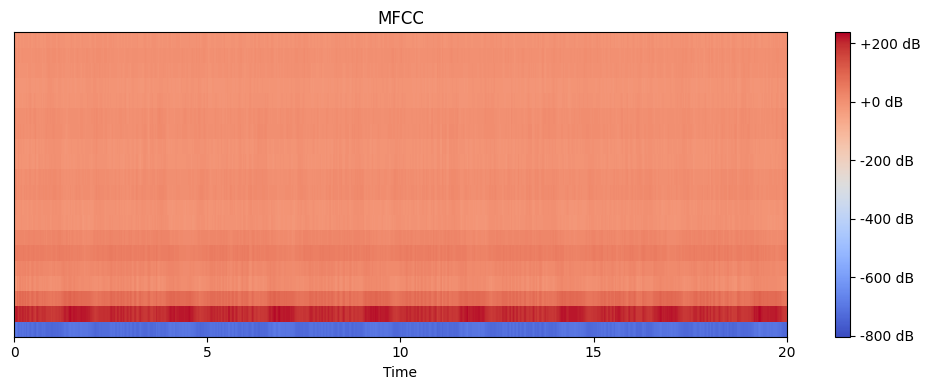

In [ ]:
# displaying Log mel spectogram
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
audio_file = "/content/drive/MyDrive/Dataset/denoised_audio/146_8p3_Pr_mc_AKGC417L.wav"
y, sr = librosa.load(audio_file)
# Compute the log mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
log_S = librosa.power_to_db(S, ref=np.max)
#compute mfcc
mfccs = librosa.feature.mfcc(S=log_S, n_mfcc=20)
# Display the MFCC spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [ ]:
# now build a cnn model using these log mel spectograms
import pandas as pd
ID=[]
CLASS=[]
path="/content/drive/MyDrive/Dataset/logmel"
for i in os.listdir(path):
  k=i.split('.')[0].split('_')
  ID.append(i)
  CLASS.append(k[1])
df=pd.DataFrame({'ID':ID,'CLASS':CLASS})
df.head()

,ID,CLASS
0,DP9_Asthma.png,Asthma
1,EP102_Healthy.png,Healthy
2,DP43_Asthma.png,Asthma
3,DP3_Asthma.png,Asthma
4,DP78_Asthma.png,Asthma


In [ ]:
from sklearn.model_selection import train_test_split
trainset_df, testset_df = train_test_split(df, test_size=0.2)

In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 839.8 kB/s eta 0:00:00


In [ ]:
from keras_preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.1)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_dataframe(
    dataframe=trainset_df,
    directory="/content/drive/MyDrive/Dataset/logmel",
    x_col="ID",
    y_col="CLASS",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

validation_set = train_datagen.flow_from_dataframe(
    dataframe=trainset_df,
    directory="/content/drive/MyDrive/Dataset/logmel",
    x_col="ID",
    y_col="CLASS",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

test_set = test_datagen.flow_from_dataframe(
    dataframe=testset_df,
    directory="/content/drive/MyDrive/Dataset/logmel",
    x_col="ID",
    y_col="CLASS",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(64,64))

Found 845 validated image filenames belonging to 8 classes.
Found 93 validated image filenames belonging to 8 classes.
Found 235 validated image filenames belonging to 8 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D, Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout,BatchNormalization

classifier = Sequential()
classifier.add(Conv2D(32, kernel_size = (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.23))
classifier.add(Flatten())

classifier.add(Dense(units= 128, activation = 'relu'))
classifier.add(Dense(units= 8, activation = 'softmax'))

classifier.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 6, 6, 64)         

In [ ]:
step_train_size=training_set.n//training_set.batch_size
step_valid_size=validation_set.n//validation_set.batch_size

classifier.fit(training_set,epochs = 50,steps_per_epoch =step_train_size,validation_data = validation_set,validation_steps =step_valid_size)

Epoch 1/50
26/26 [==============================] - 7s 191ms/step - loss: 1.1014 - accuracy: 0.6765 - val_loss: 0.7964 - val_accuracy: 0.7500
Epoch 2/50
26/26 [==============================] - 4s 165ms/step - loss: 0.9494 - accuracy: 0.7048 - val_loss: 0.6618 - val_accuracy: 0.7656
Epoch 3/50
26/26 [==============================] - 4s 156ms/step - loss: 0.9158 - accuracy: 0.7220 - val_loss: 0.5697 - val_accuracy: 0.8281
Epoch 4/50
26/26 [==============================] - 5s 179ms/step - loss: 0.8827 - accuracy: 0.7306 - val_loss: 0.6761 - val_accuracy: 0.8281
Epoch 5/50
26/26 [==============================] - 4s 165ms/step - loss: 0.8682 - accuracy: 0.7319 - val_loss: 0.8731 - val_accuracy: 0.6719
Epoch 6/50
26/26 [==============================] - 4s 166ms/step - loss: 0.8428 - accuracy: 0.7355 - val_loss: 0.7158 - val_accuracy: 0.7656
Epoch 7/50
26/26 [==============================] - 5s 189ms/step - loss: 0.8253 - accuracy: 0.7515 - val_loss: 0.7000 - val_accuracy: 0.7969
Epoch 

In [ ]:
classifier.save("/content/drive/MyDrive/Models/logcnn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_loss, test_accuracy = classifier.evaluate(test_set)

8/8 [==============================] - 1s 129ms/step - loss: 1.1541 - accuracy: 0.8298


In [ ]:
# now build a cnn model using these mfcc spectograms
import pandas as pd
import os
ID=[]
CLASS=[]
path="/content/drive/MyDrive/Dataset/mfcc"
for i in os.listdir(path):
  k=i.split('.')[0].split('_')
  ID.append(i)
  CLASS.append(k[1])
df=pd.DataFrame({'ID':ID,'CLASS':CLASS})
df.head()

,ID,CLASS
0,EP110_COPD.png,COPD
1,DP79_Asthma.png,Asthma
2,DP78_Asthma.png,Asthma
3,DP87_Healthy.png,Healthy
4,DP82_Healthy.png,Healthy


In [ ]:
from sklearn.model_selection import train_test_split
trainset_df, testset_df = train_test_split(df, test_size=0.2)

In [ ]:
training_set = train_datagen.flow_from_dataframe(
    dataframe=trainset_df,
    directory="/content/drive/MyDrive/Dataset/mfcc",
    x_col="ID",
    y_col="CLASS",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

validation_set = train_datagen.flow_from_dataframe(
    dataframe=trainset_df,
    directory="/content/drive/MyDrive/Dataset/mfcc",
    x_col="ID",
    y_col="CLASS",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

test_set = test_datagen.flow_from_dataframe(
    dataframe=testset_df,
    directory="/content/drive/MyDrive/Dataset/mfcc",
    x_col="ID",
    y_col="CLASS",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(64,64))

Found 845 validated image filenames belonging to 8 classes.
Found 93 validated image filenames belonging to 8 classes.
Found 235 validated image filenames belonging to 8 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D, Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout,BatchNormalization

classifier = Sequential()
classifier.add(Conv2D(32, kernel_size = (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.23))
classifier.add(Flatten())

classifier.add(Dense(units= 128, activation = 'relu'))
classifier.add(Dense(units= 8, activation = 'softmax'))

classifier.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
step_train_size=training_set.n//training_set.batch_size
step_valid_size=validation_set.n//validation_set.batch_size

classifier.fit(training_set,epochs = 50,steps_per_epoch =step_train_size,validation_data = validation_set,validation_steps =step_valid_size)

Epoch 1/50
26/26 [==============================] - 7s 160ms/step - loss: 1.1707 - accuracy: 0.6753 - val_loss: 1.2074 - val_accuracy: 0.6719
Epoch 2/50
26/26 [==============================] - 4s 164ms/step - loss: 1.1405 - accuracy: 0.6950 - val_loss: 1.2407 - val_accuracy: 0.6562
Epoch 3/50
26/26 [==============================] - 5s 183ms/step - loss: 1.0967 - accuracy: 0.6962 - val_loss: 1.1745 - val_accuracy: 0.6562
Epoch 4/50
26/26 [==============================] - 4s 158ms/step - loss: 1.0885 - accuracy: 0.6974 - val_loss: 1.1032 - val_accuracy: 0.6562
Epoch 5/50
26/26 [==============================] - 4s 156ms/step - loss: 1.0739 - accuracy: 0.6962 - val_loss: 1.0670 - val_accuracy: 0.6875
Epoch 6/50
26/26 [==============================] - 5s 183ms/step - loss: 1.0526 - accuracy: 0.6937 - val_loss: 1.0961 - val_accuracy: 0.6406
Epoch 7/50
26/26 [==============================] - 4s 163ms/step - loss: 1.0082 - accuracy: 0.6974 - val_loss: 1.0564 - val_accuracy: 0.6406
Epoch 

In [ ]:
# Extract features for these logmel and mfcc images using VGG-16.
import os
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
folder_path = '/content/drive/MyDrive/Dataset/logmel'
image_files = os.listdir(folder_path)
features=[]
filenames=[]
for image_file in image_files:
    # Load and preprocess the image
    img = load_img(os.path.join(folder_path, image_file), target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # Predict features for the image using VGG16
    features.append(vgg16.predict(img))
    filenames.append(image_file)

In [ ]:
feat= np.concatenate(features)
labels=[]
for i in filenames:
  k=i.split('.')[0].split('_')[1]
  if '(' in k:
    labels.append(k.split(' ')[0])
  else:
    labels.append(k)
np.save('/content/drive/MyDrive/Dataset/mfccimage_features.npy',feat)
np.save('/content/drive/MyDrive/Dataset/labels.npy', labels)

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load the features and labels
features = np.load('/content/drive/MyDrive/Dataset/mfcc30_features.npy')  # Assuming you have saved the features
labels = np.load('/content/drive/MyDrive/Dataset/labels.npy')  # Assuming you have labels for your images
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

labels_one_hot = to_categorical(labels_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_one_hot, test_size=0.2, random_state=42)
features=features.reshape((features.shape[0],-1,features.shape[-1]))
#labels_one_hot=labels_one_hot.reshape(labels_one_hot.shape[0],-1,labels_one_hot[-1])
X_train = X_train.reshape((X_train.shape[0], -1, X_train.shape[-1]))
X_test = X_test.reshape((X_test.shape[0], -1, X_test.shape[-1]))
X_train.shape

(938, 49, 512)

In [ ]:
# Define the LSTM model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.25),
    Dense(8, activation='softmax')
])
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train,y_train, epochs=50, batch_size=32, validation_split=0.2,verbose=1)


Epoch 1/50
24/24 [==============================] - 4s 30ms/step - loss: 1.1379 - accuracy: 0.6547 - val_loss: 0.8520 - val_accuracy: 0.7287
Epoch 2/50
24/24 [==============================] - 0s 10ms/step - loss: 0.8607 - accuracy: 0.7267 - val_loss: 0.8373 - val_accuracy: 0.7287
Epoch 3/50
24/24 [==============================] - 0s 11ms/step - loss: 0.7847 - accuracy: 0.7667 - val_loss: 0.8135 - val_accuracy: 0.7660
Epoch 4/50
24/24 [==============================] - 0s 9ms/step - loss: 0.7243 - accuracy: 0.7587 - val_loss: 0.7798 - val_accuracy: 0.7500
Epoch 5/50
24/24 [==============================] - 0s 11ms/step - loss: 0.6798 - accuracy: 0.7827 - val_loss: 0.7458 - val_accuracy: 0.7553
Epoch 6/50
24/24 [==============================] - 0s 11ms/step - loss: 0.6432 - accuracy: 0.7920 - val_loss: 0.7262 - val_accuracy: 0.7872
Epoch 7/50
24/24 [==============================] - 0s 11ms/step - loss: 0.5876 - accuracy: 0.8080 - val_loss: 0.7038 - val_accuracy: 0.7819
Epoch 8/50
24/

In [ ]:
#model.save("/content/drive/MyDrive/Models/mfcc30.h5")

In [ ]:
# Define the LSTM model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.25),
    Dense(8, activation='softmax')
])
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(features,labels_one_hot, epochs=50, batch_size=32, validation_split=0.25,verbose=1)


Epoch 1/50
28/28 [==============================] - 5s 55ms/step - loss: 1.0578 - accuracy: 0.6815 - val_loss: 0.9563 - val_accuracy: 0.6939
Epoch 2/50
28/28 [==============================] - 1s 19ms/step - loss: 0.7819 - accuracy: 0.7702 - val_loss: 0.9305 - val_accuracy: 0.7177
Epoch 3/50
28/28 [==============================] - 0s 12ms/step - loss: 0.7160 - accuracy: 0.7782 - val_loss: 0.9210 - val_accuracy: 0.6939
Epoch 4/50
28/28 [==============================] - 0s 12ms/step - loss: 0.6818 - accuracy: 0.7929 - val_loss: 0.8997 - val_accuracy: 0.7177
Epoch 5/50
28/28 [==============================] - 0s 11ms/step - loss: 0.6327 - accuracy: 0.7918 - val_loss: 0.8859 - val_accuracy: 0.7143
Epoch 6/50
28/28 [==============================] - 0s 11ms/step - loss: 0.5769 - accuracy: 0.8157 - val_loss: 0.8900 - val_accuracy: 0.7041
Epoch 7/50
28/28 [==============================] - 0s 11ms/step - loss: 0.5589 - accuracy: 0.8111 - val_loss: 0.8643 - val_accuracy: 0.7211
Epoch 8/50
28

In [ ]:
#model.save("/content/drive/MyDrive/Models/mfccall.h5")

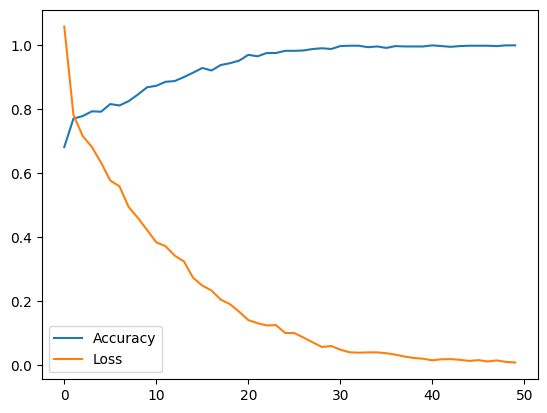

In [ ]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
loss=history.history['loss']
plt.plot(acc,label="Accuracy")
plt.plot(loss,label="Loss")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model=load_model("/content/drive/MyDrive/Models/mfccall.h5")
model.evaluate(X_test,y_test)

8/8 [==============================] - 1s 13ms/step - loss: 0.3467 - accuracy: 0.9319


[0.3467218577861786, 0.9319148659706116]

In [ ]:
pred=model.predict(features)
predicted= np.argmax(pred, axis=1)


37/37 [==============================] - 0s 4ms/step


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming you have a label encoder object called label_encoder
# And encoded labels are stored in labels_encoded

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder to your encoded labels
label_encoder.fit(labels)

# Access the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print or use the label mapping as needed
print("Label mapping:")
print(label_mapping)

Label mapping:
{'Asthma': 0, 'Bronchiectasis': 1, 'Bronchiolitis': 2, 'COPD': 3, 'Healthy': 4, 'LungFibrosis': 5, 'Pneumonia': 6, 'URTI': 7}


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming labels_encoded contains the true labels and predicted contains the predicted labels

# Compute the confusion matrix
cm = confusion_matrix(labels_encoded, predicted)

# Initialize an array to store accuracy for each class
class_accuracy = np.zeros(cm.shape[0])

# Calculate accuracy for each class
for i in range(cm.shape[0]):
    true_positive = cm[i, i]
    false_positive = np.sum(cm[:, i]) - true_positive
    false_negative = np.sum(cm[i, :]) - true_positive
    true_negative = np.sum(cm) - true_positive - false_positive - false_negative

    class_accuracy[i] = (true_positive + true_negative) / np.sum([true_positive, false_positive, false_negative, true_negative])

# Print or use class_accuracy as needed
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
  for j in label_mapping:
    if label_mapping[j]==i:
      print(f"Class {j}: {acc}")
      break


Accuracy for each class:
Class Asthma: 0.9735720375106565
Class Bronchiectasis: 0.9965899403239556
Class Bronchiolitis: 0.9982949701619779
Class COPD: 0.9437340153452686
Class Healthy: 0.9616368286445013
Class LungFibrosis: 0.9965899403239556
Class Pneumonia: 0.9863597612958227
Class URTI: 0.9948849104859335


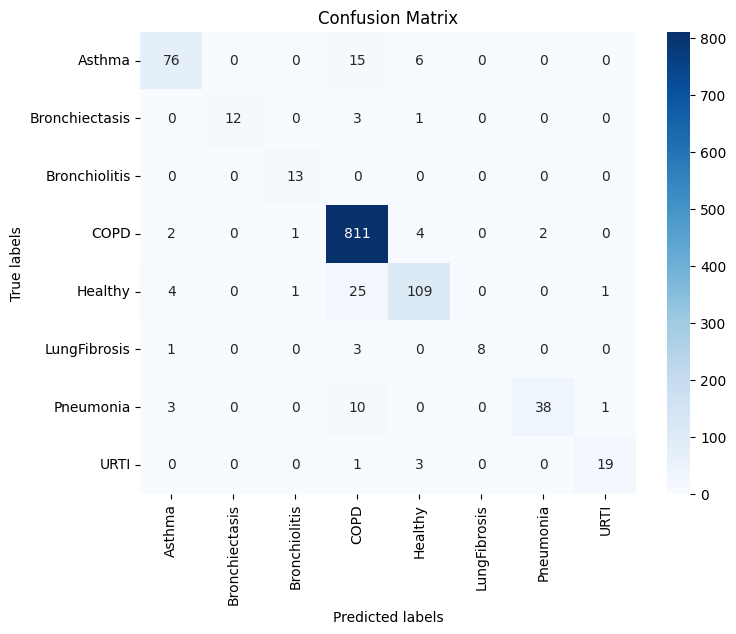

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Define class labels
classes =[j for j in label_mapping]

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true=np.argmax(y_test, axis=1)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print results
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

8/8 [==============================] - 0s 5ms/step
Precision: 0.9317737483841665
Recall: 0.9319148936170213
F1-score: 0.928308226353763


In [ ]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.preprocessing import LabelEncoder

def test(img_path):
  model = load_model('/content/drive/MyDrive/Models/mfcc30.h5')
  labels = np.load('/content/drive/MyDrive/Dataset/labels.npy')
  # Load the VGG16 model without the top classification layer
  vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  #Load and preprocess the test image
  test_image_path = img_path
  img = load_img(test_image_path, target_size=(224, 224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)

  #Extract features from the test image using VGG16
  features = vgg16.predict(img_array)


  # Make prediction using the trained LSTM model
  prediction = model.predict(features.reshape((features.shape[0], -1, features.shape[-1])))

  # Convert prediction probabilities to class labels
  label_encoder = LabelEncoder()
  labels_encoded = label_encoder.fit_transform(labels)
  predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])

  print("Predicted class:", predicted_class[0])
  print(f"Probability of predicting {predicted_class[0]}:",max(prediction[0]))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
def show(imgpath):

  # Load the image from file
  image_path =imgpath  # Provide the path to your image file
  image = np.array(Image.open(image_path))

  # Get the dimensions of the original image
  height, width, channels = image.shape

  # Specify the desired height and calculate the corresponding width to maintain the aspect ratio
  desired_height = 50 # Set the desired height
  aspect_ratio = width / height
  desired_width = 150

  # Resize the image
  resized_image = np.array(Image.fromarray(image).resize((desired_width, desired_height)))

  # Plot the resized image
  plt.imshow(resized_image)
  plt.axis('off')
  plt.show()


1/1 [==============================] - 0s 334ms/step
Predicted class: Asthma
Probability of predicting Asthma: 0.9949949


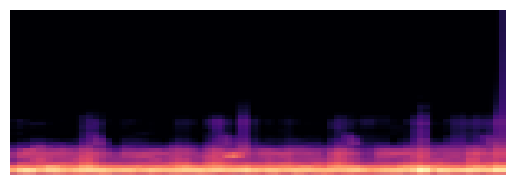

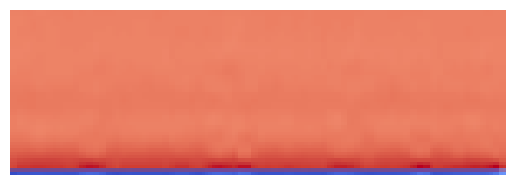

In [ ]:
#test-1
test("/content/drive/MyDrive/Dataset/mfcc30/BP55_Asthma.png")
show("/content/drive/MyDrive/Dataset/logmel/BP55_Asthma.png")
show("/content/drive/MyDrive/Dataset/mfcc30/BP55_Asthma.png")

1/1 [==============================] - 0s 308ms/step
Predicted class: Pneumonia
Probability of predicting Pneumonia: 0.9945503


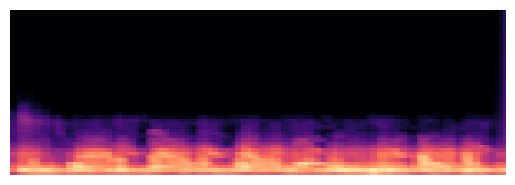

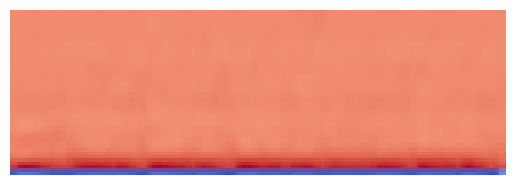

In [ ]:
#test-2
test("/content/drive/MyDrive/Dataset/mfcc30/BP37_Pneumonia.png")
show("/content/drive/MyDrive/Dataset/logmel/BP37_Pneumonia.png")
show("/content/drive/MyDrive/Dataset/mfcc30/BP37_Pneumonia.png")

1/1 [==============================] - 1s 867ms/step
Predicted class: Healthy
Probability of predicting Healthy: 0.9977847


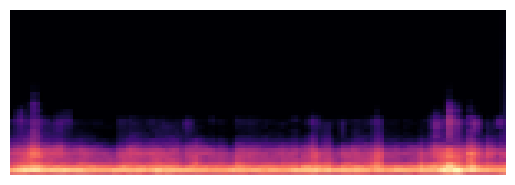

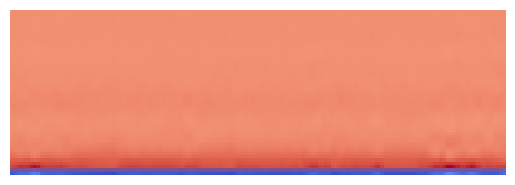

In [ ]:
#test-3
test("/content/drive/MyDrive/Dataset/mfcc30/BP48_Healthy.png")
show("/content/drive/MyDrive/Dataset/logmel/BP48_Healthy.png")
show("/content/drive/MyDrive/Dataset/mfcc30/BP48_Healthy.png")


1/1 [==============================] - 0s 321ms/step
Predicted class: LungFibrosis
Probability of predicting LungFibrosis: 0.97175646


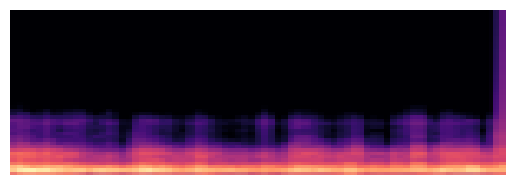

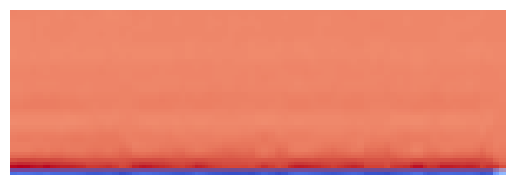

In [ ]:
#test-4
test("/content/drive/MyDrive/Dataset/mfcc30/BP52_LungFibrosis.png")
show("/content/drive/MyDrive/Dataset/logmel/BP52_LungFibrosis.png")
show("/content/drive/MyDrive/Dataset/mfcc30/BP52_LungFibrosis.png")

1/1 [==============================] - 0s 346ms/step
Predicted class: COPD
Probability of predicting COPD: 0.9931787


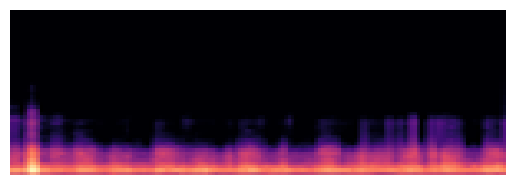

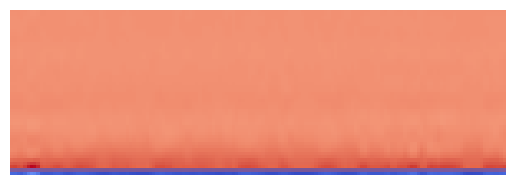

In [ ]:
#test-5
test("/content/drive/MyDrive/Dataset/mfcc30/BP61_COPD.png")
show("/content/drive/MyDrive/Dataset/logmel/BP61_COPD.png")
show("/content/drive/MyDrive/Dataset/mfcc30/BP61_COPD.png")

1/1 [==============================] - 0s 482ms/step
Predicted class: URTI
Probability of predicting URTI: 0.988226


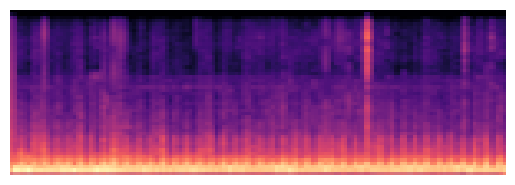

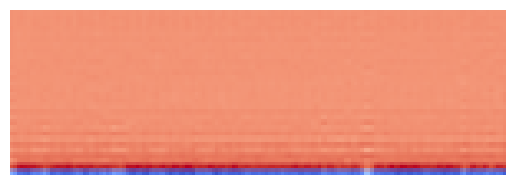

In [ ]:
#test-6
test("/content/drive/MyDrive/Dataset/mfcc30/ID1011_URTI.png")
show("/content/drive/MyDrive/Dataset/logmel/ID1011_URTI.png")
show("/content/drive/MyDrive/Dataset/mfcc30/ID1011_URTI.png")

1/1 [==============================] - 0s 365ms/step
Predicted class: Bronchiolitis
Probability of predicting Bronchiolitis: 0.9895096


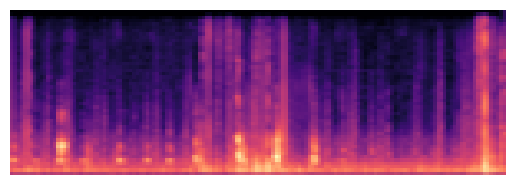

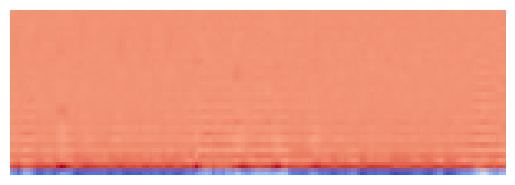

In [ ]:
#test-7
test("/content/drive/MyDrive/Dataset/mfcc30/ID1493_Bronchiolitis.png")
show("/content/drive/MyDrive/Dataset/logmel/ID1493_Bronchiolitis.png")
show("/content/drive/MyDrive/Dataset/mfcc30/ID1493_Bronchiolitis.png")

1/1 [==============================] - 0s 315ms/step
Predicted class: Bronchiectasis
Probability of predicting Bronchiectasis: 0.9951415


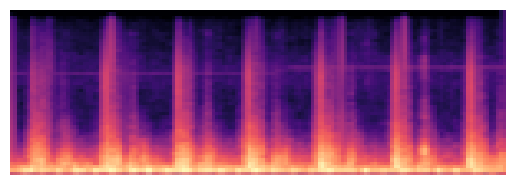

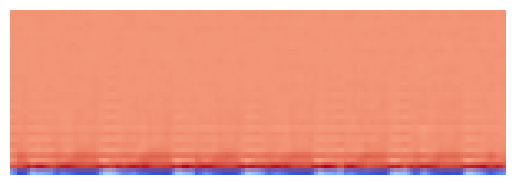

In [ ]:
#test-8
test("/content/drive/MyDrive/Dataset/mfcc30/ID1691_Bronchiectasis.png")
show("/content/drive/MyDrive/Dataset/logmel/ID1691_Bronchiectasis.png")
show("/content/drive/MyDrive/Dataset/mfcc30/ID1691_Bronchiectasis.png")

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Assuming `mfcc_features` is a NumPy array of shape (n_samples, n_features)
# Let's scale the features to have mean 0 and variance 1

mfcc_features=np.load("/content/drive/MyDrive/Dataset/mfcc30_features.npy")
mfcc_features = mfcc_features.reshape((mfcc_features.shape[0], -1))
scaler = StandardScaler()
mfcc_features_scaled = scaler.fit_transform(mfcc_features)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(mfcc_features_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
import pickle
with open('/content/drive/MyDrive/Models/kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

In [ ]:
# Calculate the mean value for each cluster
cluster_means = [mfcc_features_scaled[clusters == i].mean() for i in range(3)]

# Sort clusters by their mean values to assign severity labels
sorted_cluster_indices = np.argsort(cluster_means)

# Create a dictionary to map cluster indices to severity labels
cluster_to_severity = {sorted_cluster_indices[0]: "mild", sorted_cluster_indices[1]: "moderate", sorted_cluster_indices[2]: "severe"}

# Map each sample to its severity label
severity_labels = np.array([cluster_to_severity[cluster] for cluster in clusters])


In [ ]:
print(severity_labels)

['severe' 'severe' 'moderate' ... 'severe' 'severe' 'moderate']


In [ ]:
#testing
# Scale the new features using the same scaler as before
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Load and preprocess the test image
test_image_path = '/content/drive/MyDrive/Dataset/mfcc30/ID10710_COPD.png'
img = load_img(test_image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
# Extract features from the test image using VGG16
feature = vgg16.predict(img_array)
feature=feature.reshape(feature.shape[0], -1)
new_mfcc_features_scaled = scaler.transform(feature)
new_clusters = kmeans.predict(new_mfcc_features_scaled)
print(type(new_clusters[0]))

1/1 [==============================] - 3s 3s/step
<class 'numpy.int32'>


In [ ]:

# Map each new feature to its severity label
new_severity_labels = np.array([cluster_to_severity[cluster] for cluster in new_clusters])
print(new_severity_labels)

['moderate']
